# QRT 2021 - Reconstruction of Liquid Asset Performance 

https://challengedata.ens.fr/challenges/44/

In [ ]:
import numpy as np
from numpy.typing import ArrayLike

import polars as pl
import polars.selectors as cs

from matplotlib import pyplot as plt

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import KernelPCA
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Lasso, MultiTaskLasso
from sklearn.multioutput import RegressorChain
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

# Data preparation

In [2]:
x_train = pl.read_csv("data/x_train.csv")
y_train = pl.read_csv("data/y_train.csv")

x_test = pl.read_csv("data/x_test.csv")

# columns starting with missing values are read as String
x_train = x_train.cast({pl.String: pl.Float64})
x_test = x_test.cast({pl.String: pl.Float64})

In [3]:
# Create list of Xs and Ys which will be the columns in the dataframe
XS = x_train.select(cs.starts_with("RET_")).columns
YS = x_train["ID_TARGET"].cast(pl.String).unique(maintain_order=True).to_list()

We pivot the dataframe to pass from long to wide format, i.e. having one row per day containing all targets instead of one row per (day, target) pair.

In [4]:
train_df = x_train.join(y_train, on="ID")
train_df = train_df.pivot(index=["ID_DAY"] + XS, values="RET_TARGET", on="ID_TARGET")

# Pivot the test data to be in the same format
test_df = x_test.pivot(index=["ID_DAY"] + XS, on="ID_TARGET").drop(YS)

The original dataset has missing X values, and pivoting to wide format has introduced missing Y values as not all pairs (day, target) are present in the data provided.

We use iterative imputation to fill the missing values for both the Xs and the Ys separately.

In [5]:
imp_xs = IterativeImputer().fit(pl.concat([train_df.select(XS), test_df.select(XS)]))
imp_ys = IterativeImputer().fit(train_df.select(YS))

imp_xs.set_output(transform="polars")
imp_ys.set_output(transform="polars")

train_df = train_df.with_columns(imp_xs.transform(train_df.select(XS)))
train_df = train_df.with_columns(imp_ys.transform(train_df.select(YS)))

test_df = test_df.with_columns(imp_xs.transform(test_df.select(XS)))

Note that we could keep the data in long format and thus avoid having to fill missing Y values, if we want to restrict ourselves to model that predict all targets separately.
This does however not increase the performance of these models, as the number of missing Y values is small enough and the imputation provides a good enough estimate to not impair the models.

Using the wide format thus allows us more flexibility in the choice of models, and requires less code and computation time to fit models to individual targets, all this at no cost in performance.

# Auxiliary functions

We define some auxiliary functions, starting with a function to split the training dataframe into training and validation sets.
We use a fraction of 0.4 for the validation set as it corresponds to the fraction of test units in the entire dataset.

In [6]:
def train_valid_split(df: pl.DataFrame, seed: int, fraction: float = 0.4):
    valid_df = df.sample(fraction=fraction, seed=seed)
    train_df = df.filter(~pl.col("ID_DAY").is_in(valid_df["ID_DAY"].to_list()))

    return train_df, valid_df

Next, we define a function to compute the Custom Weighted Accuracy (CWA), which is the metric used by the challenge.

In [7]:
def cwa(y_true: ArrayLike, y_pred: ArrayLike, axis=None):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = np.sign(y_true) == np.sign(y_pred)

    return (np.abs(y_true) * mask).sum(axis=axis) / np.abs(y_true).sum(axis=axis)

Finally, we define a function which lets us evaluate a model by performing multiple training/validation splits of the training data. 
The final result is the average accuracy (CWA) over all iterations.

We use the same split in each call to this function to ensure that all models are evaluated on the same splits and that the results are therefore comparable.
We set the default number of iterations to 20 as it is the point at which the cumulative average accuracy stabilizes.

Setting `axis=0` returns the accuracy per target.

In [8]:
def evaluate_model(model, df, n_iter=20, axis=None):
    valid_acc = []

    for seed in range(n_iter):
        train_df, valid_df = train_valid_split(df, seed=seed)

        train_xs, train_ys = train_df.select(XS), train_df.select(YS)
        valid_xs, valid_ys = valid_df.select(XS), valid_df.select(YS)

        predts = model.fit(train_xs, train_ys).predict(valid_xs)
        valid_acc.append(cwa(valid_ys, predts, axis=axis))

    return np.array(valid_acc).mean(axis=axis)

Remark that this evaluation function includes the imputed values of Y in the targets.
For some reason, this results in an accuracy score very close to what we obtain when submitting,
while including only the targets initially part of the dataset (e.g. by filling the nulls of `valid_ys` with zero)
results in an accuracy lower by about 0.2%.

# Individual models

We define individual models (i.e. not ensemble models) and evaluate them on the training set.

We start by creating a class for Kernel Principal Component Regression (kPCR).
We use a custom class instead of a pipeline as we want to be able to fit the kPCA to the entire set of Xs (training and validation/test) instead of just the training set.

In [10]:
class KernelPCR:
    def __init__(self, regressor, kpca):
        self.regressor = regressor
        self.kpca = make_pipeline(StandardScaler(), kpca)

    def fit(self, xs, ys):
        self.regressor.fit(self.kpca.transform(xs), ys)

        return self

    def predict(self, xs):
        return self.regressor.predict(self.kpca.transform(xs))

We choose several models which all perform reasonably well on average (as we will see).
Note that the XGB model is much slower to fit than all others, but its inclusion will be justified when averaging the models.

In [11]:
models = {
    "Lasso": Lasso(3e-5),
    "Chain": RegressorChain(Lasso(3e-5)),
    "kPCR": KernelPCR(MultiTaskLasso(3e-4), KernelPCA(100, kernel="cosine")),
    "PLSR": PLSRegression(15),
    "XGBR": XGBRegressor(
        tree_method="hist", learning_rate=0.1, max_depth=2, n_estimators=75, reg_alpha=1
    ),
}

# Fit the kPCA on all of the training data for evaluation
_ = models["kPCR"].kpca.fit(train_df.select(XS))

We evaluate the models and store the accuracy per target.

In [12]:
evals = {key: evaluate_model(model, train_df, axis=0) for key, model in models.items()}

We compute the global accuracy, which is given by the weighted sum of local (i.e. per target) accuracies.

In [13]:
# Compute the weight of each target
weights = np.abs(train_df.select(YS)).sum(axis=0) / np.abs(train_df.select(YS)).sum()

# Compute the global accuracy (CWA) for each model
global_evals = {key: np.sum(val * weights) for key, val in evals.items()}

# Print the global accuracy of each model
for key, val in global_evals.items():
    print(f"{key}: \t {val * 100:.2f} %")

Lasso: 	 74.21 %
Chain: 	 74.28 %
kPCR: 	 74.26 %
PLSR: 	 73.84 %
XGBR: 	 74.17 %


We plot the accuracy per target of each model.

Observe that the best model for each target varies, and that the targets for which the accuracy is low 
are the ones where there is the most difference between models.
This can be explained by the fact that these are the targets whose values are close to zero, making them
more difficult to predict as small variations result in changes of sign.


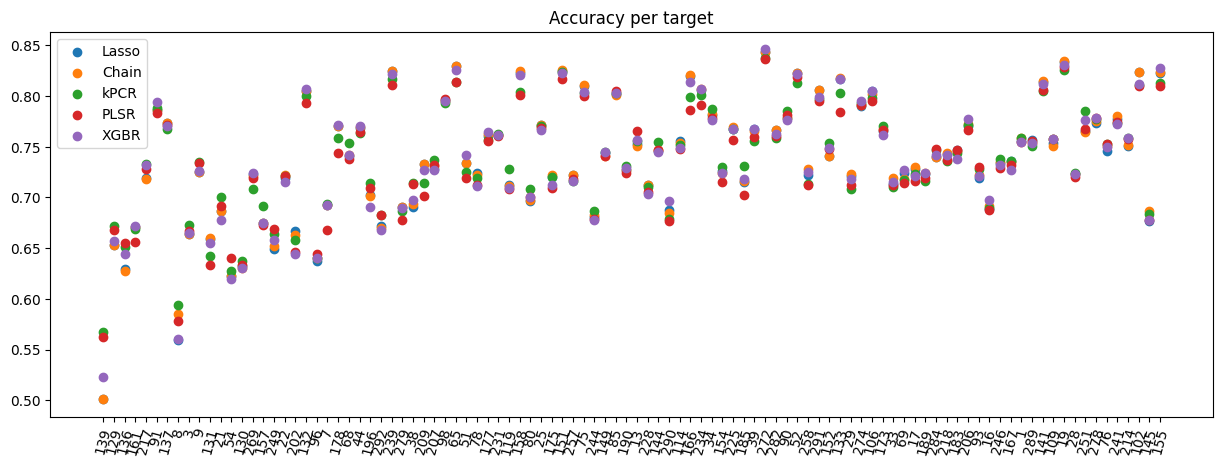

In [14]:
plt.figure(figsize=(15, 5))

for name, eval in evals.items():
    plt.scatter(x=YS, y=eval, label=name)

plt.xticks(rotation=75)
plt.title("Accuracy per target")
plt.legend()
plt.show()

Finally, we remark that these models are not fully optimized.
One could for instance optimize the parameter $\alpha$ of the single-target Lasso 
(e.g.with `MultiOutputRegressor(LassoCV())`) to determine the optimal value for each target, 
which results in slightly higher accuracy for the model (+0.1%).
One can also use bagging (e.g. via sklearn's `BaggingRegressor`) to improve model performance by reducing variance.

These methods however have little to no impact on the average model of the next section and require more training time, 
so we choose to ignore them.

# Average model

We now construct a model which averages the predictions of the models defined earlier.

The idea is to use the average as a form of weighted voting since we are only interested in the sign of the prediction.
If the predictions of all models are within reasonable distance of the true value of a target, 
then we would expect that averaging would reduce variance.
On the other hand, if some models cannot correctly predict certain points due to their nature, 
then they should do so with "low confidence", i.e. by predicting the wrong sign with low magnitude.
If another model can capture the correct sign of those points, its predictions can outweigh the incorrect
ones and tip the sign to attain correct classification.

For this reason, it is useful to include a variety of models, even if those do not perform as well individually 
as others. This is the case for the PLS Regressor and the XGBoost models, which are the worst individual models,
but do improve the performance of the average.
It also makes sense to exclude certain models which do perform well if they do not move the predictions away form zero.
This is the case of the Ridge model (with $\alpha=1$) which preforms reasonably well individually but by nature
pushed the predictions towards zero, therefore making the average less stable.


Note that since we are only interested in the sign of the prediction, it would suffice to take the sum
of the predictions instead of the average.
This would make the model a classifier only, while taking the average allows us to use it as a regressor.

In [15]:
class AverageModel:
    def __init__(self, models):
        self.models = models

    def fit(self, xs, ys):
        self.models = [model.fit(xs, ys) for model in self.models]
        return self

    def predict(self, xs):
        predts = [model.predict(xs) for model in self.models]

        return np.add.reduce(predts) / len(predts)

In [16]:
avg_model = AverageModel(models.values())

avg_eval = evaluate_model(avg_model, train_df, axis=0)

print(f"Average Model: {np.sum(avg_eval * weights) * 100:.2f} %")

Average Model: 74.76 %


Adding the performance of the average model to the plot above shows that the average model attains 
the performance of the best model for almost all targets.

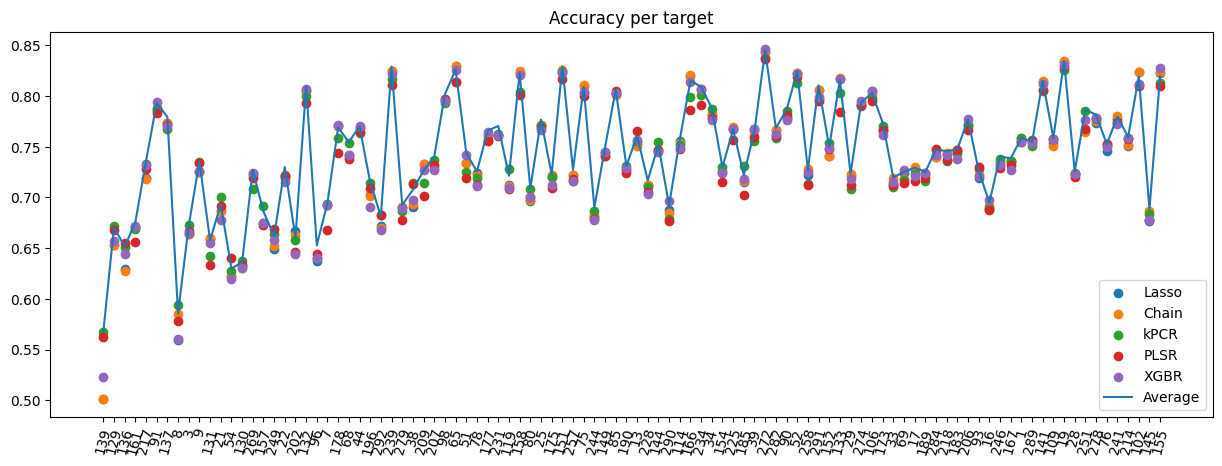

In [17]:
plt.figure(figsize=(15, 5))

for name, eval in evals.items():
    plt.scatter(x=YS, y=eval, label=name)

plt.plot(YS, avg_eval, label="Average")

plt.xticks(rotation=75)
plt.title("Accuracy per target")
plt.legend()
plt.show()

One could be tempted, by looking at this plot, to choose the best model for each target instead of using the average.
This seems like a reasonable approach, but it is practically difficult to determine which model is best 
in a stable manner, as one needs sub-sampling of the training set and it turns out that this results in 
a highly volatile final model, whose performance ends up being worse than that of the average model 
(from the testing conducted with the models here plus a few others).
Moreover, the performance of the average model is very close to that of the best model for each target,
so that what is potentially lost in accuracy is regained in stability.

# Submission

We can now train the average model on the full dataset and predict the test set.

In [18]:
model = avg_model.fit(train_df.select(XS), train_df.select(YS))

In [19]:
predt = pl.DataFrame(model.predict(test_df.select(XS)), schema=YS)

# Unpivot the dataframe to long format
predt = (
    predt.with_columns(test_df["ID_DAY"])
    .unpivot(on=YS, index="ID_DAY", variable_name="ID_TARGET", value_name="RET_TARGET")
    .cast({"ID_TARGET": pl.Int64})
)

# Join with x_test to only retain the entries in the test set
predt = (
    x_test.select("ID", "ID_DAY", "ID_TARGET")
    .join(predt, on=["ID_DAY", "ID_TARGET"], coalesce=True)
    .sort(by="ID")
)

predt = predt.select("ID", pl.col("RET_TARGET").sign().cast(pl.Int64))

In [20]:
predt.write_csv("submission.csv")